User Experience Analysis

In [1]:
import pickle
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
import os , sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from data_selector import *
from data_visualizer import *
from data_outlier_handler import OutlierHandler

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
pd.set_option('display.max_columns', 100)

Reading Data

In [8]:
df = pd.read_csv("../Data/cleaned_Tellco_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60586 entries, 0 to 60585
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        60586 non-null  int64  
 1   Bearer Id                         60586 non-null  int64  
 2   Start                             60586 non-null  object 
 3   Start ms                          60586 non-null  float64
 4   End                               60586 non-null  object 
 5   End ms                            60586 non-null  float64
 6   IMSI                              60586 non-null  int64  
 7   MSISDN/Number                     60586 non-null  int64  
 8   IMEI                              60586 non-null  int64  
 9   Last Location Name                60586 non-null  object 
 10  Avg RTT DL (ms)                   60586 non-null  float64
 11  Avg RTT UL (ms)                   60586 non-null  float64
 12  Avg 

User Experience Metrics

In [9]:
user_experience_df = df[[
    'MSISDN/Number',
    'Avg RTT DL (ms)',
    'Avg RTT UL (ms)',
    'Avg Bearer TP DL (kbps)',
    'Avg Bearer TP UL (kbps)',
    'TCP DL Retrans. Vol (Bytes)',
    'TCP UL Retrans. Vol (Bytes)',
    'Handset Type']]

In [10]:
# caluclate the totals
user_experience_df['Total Avg RTT (ms)'] = user_experience_df['Avg RTT DL (ms)'] + user_experience_df['Avg RTT UL (ms)']
user_experience_df['Total Avg Bearer TP (kbps)'] = user_experience_df['Avg Bearer TP DL (kbps)'] + user_experience_df['Avg Bearer TP UL (kbps)']
user_experience_df['Total TCP Retrans. Vol (Bytes)'] = user_experience_df['TCP DL Retrans. Vol (Bytes)'] + user_experience_df['TCP UL Retrans. Vol (Bytes)']
user_experience_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60586 entries, 0 to 60585
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MSISDN/Number                   60586 non-null  int64  
 1   Avg RTT DL (ms)                 60586 non-null  float64
 2   Avg RTT UL (ms)                 60586 non-null  float64
 3   Avg Bearer TP DL (kbps)         60586 non-null  float64
 4   Avg Bearer TP UL (kbps)         60586 non-null  float64
 5   TCP DL Retrans. Vol (Bytes)     60586 non-null  float64
 6   TCP UL Retrans. Vol (Bytes)     60586 non-null  float64
 7   Handset Type                    60586 non-null  object 
 8   Total Avg RTT (ms)              60586 non-null  float64
 9   Total Avg Bearer TP (kbps)      60586 non-null  float64
 10  Total TCP Retrans. Vol (Bytes)  60586 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 5.1+ MB


In [11]:
user_experience_df.head()

,MSISDN/Number,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),TCP DL Retrans. Vol (Bytes),TCP UL Retrans. Vol (Bytes),Handset Type,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
0,33763490140,39.0,18.0,3698.0,416.0,19520.0,7230.0,unknown,57.0,4114.0,26750.0
1,33659219748,97.0,7.0,3845.0,2535.0,3231397.0,7230.0,Samsung Galaxy Note 8 (Sm-N950F Ds),104.0,6380.0,3238627.0
2,33664473872,217.0,4.0,28305.0,6500.0,5722628.0,312007.0,Huawei B593S-22,221.0,34805.0,6034635.0
3,33659219748,79.0,4.0,4148.0,4540.0,32754526.0,34638.0,Samsung Galaxy Note 8 (Sm-N950F Ds),83.0,8688.0,32789164.0
4,33753758738,39.0,33.0,263.0,620.0,12964929.0,882193.0,Samsung Galaxy J3 (Sm-J330),72.0,883.0,13847122.0


In [12]:
# select the necessary columns
user_experience_df = user_experience_df[['MSISDN/Number', 'Handset Type', 'Total Avg RTT (ms)',
    'Total Avg Bearer TP (kbps)', 'Total TCP Retrans. Vol (Bytes)']]
user_experience_df.head()

,MSISDN/Number,Handset Type,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
0,33763490140,unknown,57.0,4114.0,26750.0
1,33659219748,Samsung Galaxy Note 8 (Sm-N950F Ds),104.0,6380.0,3238627.0
2,33664473872,Huawei B593S-22,221.0,34805.0,6034635.0
3,33659219748,Samsung Galaxy Note 8 (Sm-N950F Ds),83.0,8688.0,32789164.0
4,33753758738,Samsung Galaxy J3 (Sm-J330),72.0,883.0,13847122.0


In [13]:
# aggregating user experience metrics per user
user_experience_df1 = user_experience_df.groupby(
    'MSISDN/Number').agg({
        'Total Avg RTT (ms)': 'sum',
        'Total Avg Bearer TP (kbps)': 'sum',
        'Total TCP Retrans. Vol (Bytes)': 'sum',
        'Handset Type': [lambda x: x.mode()[0]]})
user_experience_df1.head()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes),Handset Type
,sum,sum,sum,<lambda>
MSISDN/Number,,,,
33601007832,84.0,248.0,2396.0,Apple iPhone 5S (A1457)
33601008617,91.0,56781.0,9370832.0,Apple iPhone Se (A1723)
33601010682,24.0,7787.0,3190.0,Samsung Galaxy A8 (2018)
33601011634,39.0,42416.0,110232.0,Huawei Mate 10 Pro Porsche Design Huawei Mate 10
33601011959,52.0,1247.0,11569.0,Samsung Galaxy S8 Plus (Sm-G955F)


In [14]:
user_experience_df = pd.DataFrame(columns=[
    "Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)",
    "Handset Type"])

user_experience_df["Total Avg RTT (ms)"] = user_experience_df1["Total Avg RTT (ms)"]['sum']
user_experience_df["Total Avg Bearer TP (kbps)"] = user_experience_df1["Total Avg Bearer TP (kbps)"]['sum']
user_experience_df["Total TCP Retrans. Vol (Bytes)"] = user_experience_df1["Total TCP Retrans. Vol (Bytes)"]['sum']
user_experience_df["Handset Type"] = user_experience_df1["Handset Type"]['<lambda>']
user_experience_df.head()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes),Handset Type
MSISDN/Number,,,,
33601007832,84.0,248.0,2396.0,Apple iPhone 5S (A1457)
33601008617,91.0,56781.0,9370832.0,Apple iPhone Se (A1723)
33601010682,24.0,7787.0,3190.0,Samsung Galaxy A8 (2018)
33601011634,39.0,42416.0,110232.0,Huawei Mate 10 Pro Porsche Design Huawei Mate 10
33601011959,52.0,1247.0,11569.0,Samsung Galaxy S8 Plus (Sm-G955F)


Top 10 values of the experience metrics

In [15]:
# top 10 rtt values in the dataset

rtt = user_experience_df.sort_values('Total Avg RTT (ms)', ascending=False)
top_10 = rtt.head(10)['Total Avg RTT (ms)']
bottom_10 = rtt.tail(10)['Total Avg RTT (ms)']
most_10 = user_experience_df['Total Avg RTT (ms)'].value_counts().head(10)

In [17]:
multi_hist([top_10, bottom_10, most_10], 1, 3,
    "RTT values in the dataset", ['Top 10', 'Bottom 10', 'Most 10'])

In [18]:
# top 10 tp values in the dataset

tp = user_experience_df.sort_values('Total Avg Bearer TP (kbps)', ascending=False)
top_10 = tp.head(10)['Total Avg Bearer TP (kbps)']
bottom_10 = tp.tail(10)['Total Avg Bearer TP (kbps)']
most_10 = user_experience_df['Total Avg Bearer TP (kbps)'].value_counts().head(10)

In [19]:
multi_hist([top_10, bottom_10, most_10], 1, 3,
    "TP values in the dataset", ['Top 10', 'Bottom 10', 'Most 10'])

In [20]:
# top 10 tcp values in the dataset

tcp = user_experience_df.sort_values('Total TCP Retrans. Vol (Bytes)', ascending=False)
top_10 = tcp.head(10)['Total TCP Retrans. Vol (Bytes)']
bottom_10 = tcp.tail(10)['Total TCP Retrans. Vol (Bytes)']
most_10 = user_experience_df['Total TCP Retrans. Vol (Bytes)'].value_counts().head(10)

In [22]:
multi_hist([top_10, bottom_10, most_10], 1, 3,
    "TCP values in the dataset", ['Top 10', 'Bottom 10', 'Most 10'])

Average values of experience metrics per handset type

In [23]:
handset_type_df = user_experience_df.groupby('Handset Type').mean()
handset_type_df.head()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
Handset Type,,,
A-Link Telecom I. Cubot Note Plus,1589.0,6699.0,616213.0
A-Link Telecom I. Cubot Note S,890.0,8937.0,41411731.0
A-Link Telecom I. Cubot Nova,44.0,56217.0,137170.0
A-Link Telecom I. Cubot Power,43.0,69468.0,8041.0
A-Link Telecom I. Cubot R9,231.0,4039.0,30999.0


In [24]:
# sorting per tp
tp = handset_type_df.sort_values(
    'Total Avg Bearer TP (kbps)', ascending=False)
tp.head()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
Handset Type,,,
Asustek Wireless-Ac1200 Lte Router,324.0,250978.000000,1.754793e+07
Spa Condor Elect. Allure M2,90.0,168623.000000,8.901600e+04
Huawei Par-Lx9,259.0,144115.000000,2.896635e+06
Huawei B715S-23C,153.6,141692.500000,4.473797e+07
Tp-Link Technolo. Tl-Mr6400,687.0,135057.666667,6.633223e+07


In [25]:
# sorting per tcp
tcp = handset_type_df.sort_values(
    'Total TCP Retrans. Vol (Bytes)', ascending=False)
tcp.head()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
Handset Type,,,
Lg Lg-H635,103.5,36436.5,1.357302e+09
Huawei Bln-Al10,292.0,5761.0,3.291746e+08
Asustek Asus Zenfone Selfie Zd551Kl,121.5,27585.0,3.216583e+08
Dynamic Tech Hol. D-Mobile I3 I5 I7 I8 I9,110.0,752.0,2.683127e+08
Samsung Galaxy Tab S3 (Sm-T825),121.5,34720.0,2.533225e+08


Outliers

In [26]:
user_experience_df = user_experience_df[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]]

In [27]:
outlier_handler = OutlierHandler(user_experience_df)

<Axes: >

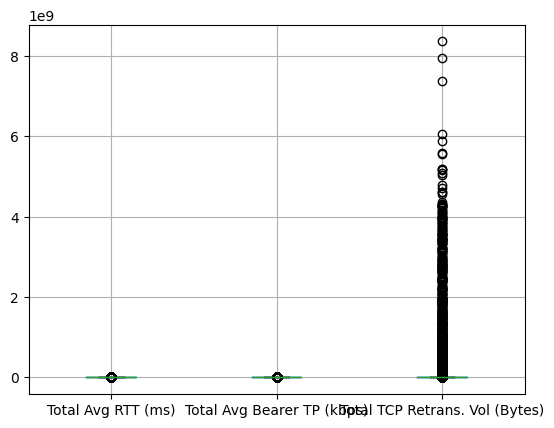

In [28]:
user_experience_df.boxplot()

In [29]:
outlier_handler.getOverview(["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"])

Name of columns,Total TCP Retrans. Vol (Bytes),Total Avg RTT (ms),Total Avg Bearer TP (kbps)
Min,51.0,16.0,5.0
Q1,64778.0,52.0,9970.5
Median,586154.0,84.0,30223.0
Q3,4223305.0,186.0,60177.5
Max,8354209105.0,54848.0,840424.0
IQR,4158527.0,134.0,50207.0
Lower fence,-6173012.5,-149.0,-65340.0
Upper fence,10461095.5,387.0,135488.0
Skew,15.702775,23.868407,2.951327
Number_of_outliers,7353,5402,2789


In [30]:
outlier_handler.replace_outliers_with_fences(["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"])

In [31]:
outlier_handler.getOverview(["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"])

Name of columns,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
Min,16.0,5.0,51.0
Q1,52.0,9970.5,64778.0
Median,84.0,30223.0,586154.0
Q3,186.0,60177.5,4223305.0
Max,387.0,135488.0,10461095.5
IQR,134.0,50207.0,4158527.0
Lower fence,-149.0,-65340.0,-6173012.5
Upper fence,387.0,135488.0,10461095.5
Skew,1.185724,1.069155,1.202294
Number_of_outliers,0,0,0


In [32]:
user_experience_df.boxplot()

<Axes: >

K-means Clustering

In [33]:
# scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_experience_df)
scaled_data

array([[-0.46020878, -1.06077518, -0.72276613],
       [-0.40015574,  0.40452977,  1.70743904],
       [-0.97494914, -0.86536836, -0.72256017],
       ...,
       [-0.73473697,  2.44457288,  0.00398081],
       [-0.58889387,  2.44457288, -0.72076873],
       [-0.73473697, -0.79854798, -0.66682603]], shape=(48011, 3))

In [34]:
normalized_data = normalize(scaled_data)
normalized_data

array([[-0.33749344, -0.77791794, -0.53003949],
       [-0.22233904,  0.22476939,  0.94870652],
       [-0.6541248 , -0.58060353, -0.48478891],
       ...,
       [-0.28783813,  0.9576778 ,  0.00155951],
       [-0.22513234,  0.93455278, -0.27554769],
       [-0.57687689, -0.62697795, -0.52355678]], shape=(48011, 3))

In [35]:
kmeans = KMeans(n_clusters=3, random_state=1).fit(normalized_data)
kmeans.labels_

array([1, 2, 1, ..., 2, 2, 1], shape=(48011,), dtype=int32)

In [36]:
user_experience_df.insert(0, 'cluster', kmeans.labels_)
user_experience_df

,cluster,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
MSISDN/Number,,,,
33601007832,1,84.0,248.0,2396.0
33601008617,2,91.0,56781.0,9370832.0
33601010682,1,24.0,7787.0,3190.0
33601011634,1,39.0,42416.0,110232.0
33601011959,1,52.0,1247.0,11569.0
...,...,...,...,...
33789914536,1,70.0,554.0,2734889.0
33789922012,1,128.0,43305.0,1229545.0
33789942399,2,52.0,135488.0,2804004.0


In [37]:
user_experience_df['cluster'].value_counts()

cluster
1    24112
2    15413
0     8486
Name: count, dtype: int64

In [38]:
fig = px.scatter(user_experience_df, x='Total TCP Retrans. Vol (Bytes)', y='Total Avg Bearer TP (kbps)',
                 color='cluster', size='Total Avg RTT (ms)')
fig.show()

In [39]:
cluster0 = user_experience_df[user_experience_df["cluster"]==0]
cluster0[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
count,8486.000000,8486.000000,8.486000e+03
mean,295.471011,15446.457106,1.730960e+06
std,90.259802,17666.060048,2.552747e+06
min,110.000000,17.000000,1.820000e+02
25%,207.000000,1981.250000,9.108900e+04
50%,309.000000,9147.500000,5.787860e+05
75%,387.000000,22266.500000,2.274910e+06
max,387.000000,104504.000000,1.046110e+07


In [40]:
cluster1 = user_experience_df[user_experience_df["cluster"]==1]
cluster1[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
count,24112.000000,24112.000000,2.411200e+04
mean,64.383751,26005.530690,4.735665e+05
std,28.079881,20789.881767,8.170267e+05
min,16.000000,5.000000,5.100000e+01
25%,44.000000,7824.250000,2.195825e+04
50%,57.000000,22454.500000,1.116670e+05
75%,78.000000,40121.500000,5.194585e+05
max,159.000000,92593.000000,6.538752e+06


In [41]:
cluster2 = user_experience_df[user_experience_df["cluster"]==2]
cluster2[["Total Avg RTT (ms)",
    "Total Avg Bearer TP (kbps)",
    "Total TCP Retrans. Vol (Bytes)"]].describe()

,Total Avg RTT (ms),Total Avg Bearer TP (kbps),Total TCP Retrans. Vol (Bytes)
count,15413.000000,15413.000000,1.541300e+04
mean,165.355155,79067.811069,6.992714e+06
std,117.163520,40354.385556,3.871210e+06
min,21.000000,166.000000,3.380000e+02
25%,72.000000,46821.000000,3.313244e+06
50%,121.000000,77488.000000,8.924270e+06
75%,238.000000,115698.000000,1.046110e+07
max,387.000000,135488.000000,1.046110e+07


Saving Data

In [42]:
# save the dataframe
user_experience_df.to_csv('../data/user_experience_data.csv')

In [43]:
# save the clustering model
with open("../models/user_experience.pkl", "wb") as f:
    pickle.dump(kmeans, f)